In [ ]:
!pip install --upgrade qiskit
!pip install --upgrade qiskit-ibm-runtime

In [61]:
import math
pi=math.pi
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

In [27]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit.providers.basic_provider import BasicProvider 
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

## Hayden-Preskill decoding protocol

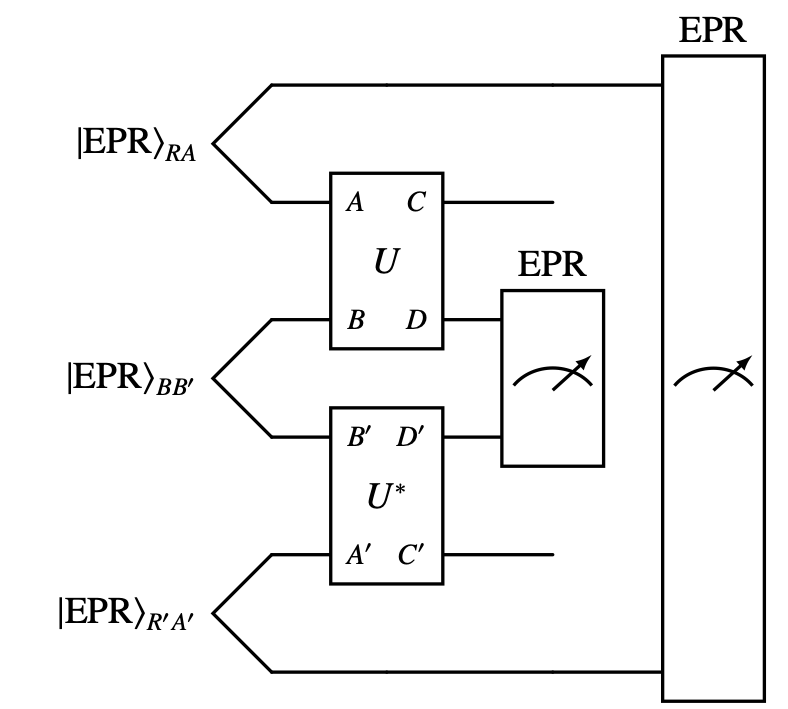

In [28]:
def F_haar(NA,ND):
    dA = 2**NA
    dD = 2**ND
    return 1/(1+(dA/dD)**2-dD**(-2))

def P_haar(NA,ND):
    dA = 2**NA
    dD = 2**ND
    return dA**(-2) + dD**(-2)-(dA*dD)**(-2)


In [51]:
def X(qc,q,theta):
    """
    exp(-i*theta*X)
    """
    qc.rx(2*theta,q)
        
def Z(qc,q,theta):
    """
    exp(-i*theta*Z)
    """
    qc.rz(2*theta,q)
      
def ZZ(qc,q0,q1,theta):
    """
    exp(-i*theta*Z0*Z1)
    """
    qc.cx(q1,q0)
    qc.rz(2*theta,q0)
    qc.cx(q1,q0)


In [52]:
def U_ising(qc,q,h,m,dt):
    """
    exp(-i*dt*H_ising)
    h: coeff of transverse field
    m: coeff of longitudinal field
    """
    N = len(q)

    for i in range(N):
        X(qc,q[i],h*dt)

    for i in range(N):
        Z(qc,q[i],m*dt)

    for i in range(N-1):
        ZZ(qc,q[i],q[i+1],dt)
    #ZZ(qc,q[N-1],q[0],dt)

def Ising_fidelity(N,NA,ND,h,m,dt,T,shots=512):

    NB=N-NA
    NC=N-ND
    backend = BasicSimulator()
    M= int(T/dt)
    times = np.arange(M+1)

    Pepr_arr = []
    Fepr_arr = []
    for time in times:

        qAAp = QuantumRegister(2*NA,"qAAp")
        qBBp = QuantumRegister(2*NB,"qBBp")
        qRRp = QuantumRegister(2*NA,"qRp")
        c = ClassicalRegister(2*ND+2*NA,"c")
        qc = QuantumCircuit(qAAp,qBBp,qRRp,c)

        for i in range(NB):
            qc.h(qBBp[i]); qc.cx(qBBp[i],qBBp[i+NB])
        for i in range(NA):
            qc.h(qAAp[i]); qc.cx(qAAp[i],qRRp[i])
            qc.h(qAAp[i+NA]); qc.cx(qAAp[i+NA],qRRp[i+NA])

        qAB = []
        qABp= []
        for n in range(NA):
            qAB.append(qAAp[n])
            qABp.append(qAAp[n+NA])
        for n in range(NB):
            qAB.append(qBBp[n])
            qABp.append(qBBp[n+NB])
        for _ in range(time):
            U_ising(qc,qAB,h,m,dt)
            U_ising(qc,qABp,h,m,-dt)

        # Bell measurement on DD'
        for i in range(ND):
            qc.cx(qBBp[NB-ND+i],qBBp[-ND+i]); qc.h(qBBp[NB-ND+i])
        # Bell measurement on RR'
        for i in range(NA):
            qc.cx(qRRp[i],qRRp[i+NA]); qc.h(qRRp[i])

        for i in range(ND):
            qc.measure(qBBp[NB-ND+i],c[i])
            qc.measure(qBBp[-ND+i],c[i+ND])
        for i in range(NA):
            qc.measure(qRRp[i],c[i+2*ND])
            qc.measure(qRRp[i+NA],c[i+NA+2*ND])

        sampler= BackendSampler(backend=backend)
        counts = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()

        proj_counts = {}
        proj_shots = 0
        for digit,count in counts.items():
            digit = digit[::-1] ## qiskit は右端を0番目としてビットが並んでいるので反転させる --> |i_1i_2...i_N> のビットストリング
            if digit[:2*ND]=="0"*(2*ND):
                proj_shots += count
                proj_counts[digit[-2*NA:]] = count

        Pepr_arr.append(proj_shots/shots)
        Fepr_arr.append(proj_counts["0"*(2*NA)]/proj_shots)
    
    return Pepr_arr, Fepr_arr

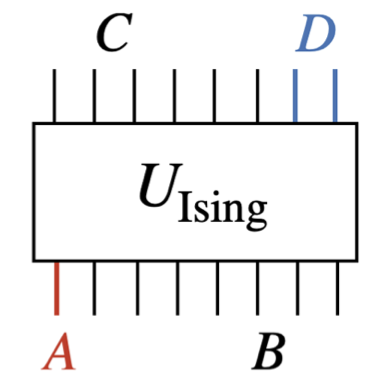

In [41]:
N=8
NA=1
ND=2
NB=N-NA
NC=N-ND
dt=0.1
T=10
M= int(T/dt)
times = np.arange(M+1)

h=1.05; m=0.5
Pepr_ch,Fepr_ch = Ising_fidelity(N,NA,ND,h,m,dt,T)

h=1; m=0
Pepr_cr,Fepr_cr = Ising_fidelity(N,NA,ND,h,m,dt,T)

h=0; m=0
Pepr_cl,Fepr_cl = Ising_fidelity(N,NA,ND,h,m,dt,T)

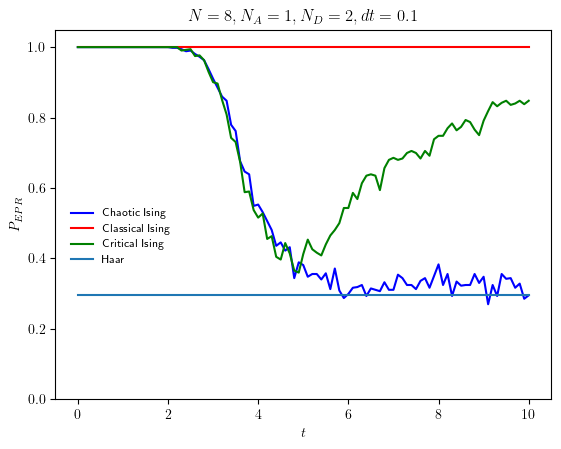

In [42]:
plt.plot(dt*times,Pepr_ch,"b-",label="Chaotic Ising")
plt.plot(dt*times,Pepr_cl,"r-",label="Classical Ising")
plt.plot(dt*times,Pepr_cr,"g-",label="Critical Ising")
plt.plot(dt*times,P_haar(NA,ND)+0*dt*times,"-",label="Haar")
plt.xlabel("$t$")
plt.ylabel(r"$P_{EPR}$")
plt.ylim([0,1.05])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}, dt={dt}$")
legend=plt.legend(bbox_to_anchor=(0.0, 0.32), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

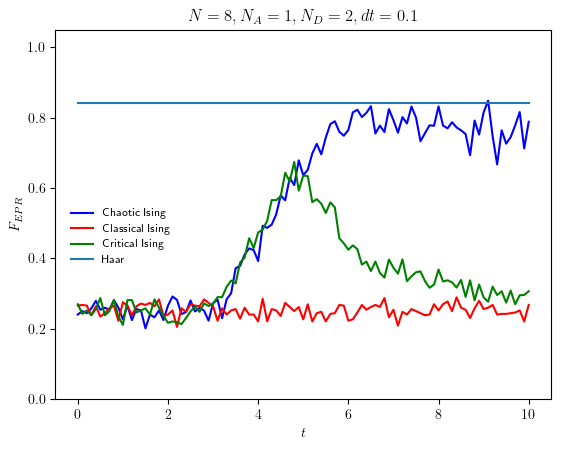

In [43]:
plt.plot(dt*times,Fepr_ch,"b-",label="Chaotic Ising")
plt.plot(dt*times,Fepr_cl,"r-",label="Classical Ising")
plt.plot(dt*times,Fepr_cr,"g-",label="Critical Ising")
plt.plot(dt*times,F_haar(NA,ND)+0*dt*times,"-",label="Haar")
plt.xlabel("$t$")
plt.ylabel(r"$F_{EPR}$")
plt.ylim([0,1.05])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}, dt={dt}$")
legend=plt.legend(bbox_to_anchor=(0.0, 0.32), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

# Floquet scrambling circuit

dtを大きくとると短いステップでHaar randomに漸近することを確認する

In [65]:
N=8
NA=1
ND=2
NB=N-NA
NC=N-ND
dt=pi/4
M= 20 #int(T/dt)
T= M*dt
times = np.arange(M+1)

h=1.05; m=0.5
Pepr_ch,Fepr_ch = Ising_fidelity(N,NA,ND,h,m,dt,T)

h=1; m=0
Pepr_cr,Fepr_cr = Ising_fidelity(N,NA,ND,h,m,dt,T)

h=0; m=0
Pepr_cl,Fepr_cl = Ising_fidelity(N,NA,ND,h,m,dt,T)

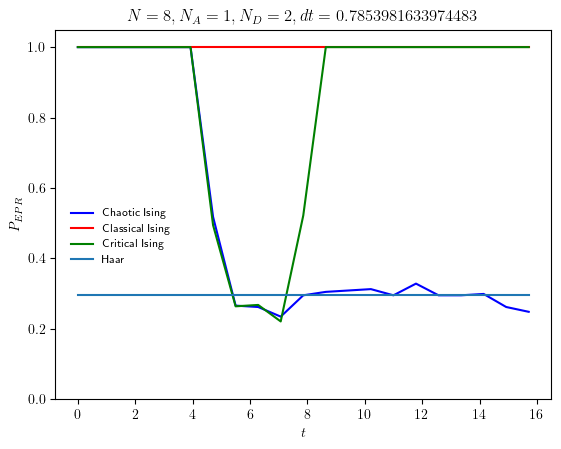

In [66]:
plt.plot(dt*times,Pepr_ch,"b-",label="Chaotic Ising")
plt.plot(dt*times,Pepr_cl,"r-",label="Classical Ising")
plt.plot(dt*times,Pepr_cr,"g-",label="Critical Ising")
plt.plot(dt*times,P_haar(NA,ND)+0*dt*times,"-",label="Haar")
plt.xlabel("$t$")
plt.ylabel(r"$P_{EPR}$")
plt.ylim([0,1.05])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}, dt={dt}$")
legend=plt.legend(bbox_to_anchor=(0.0, 0.32), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

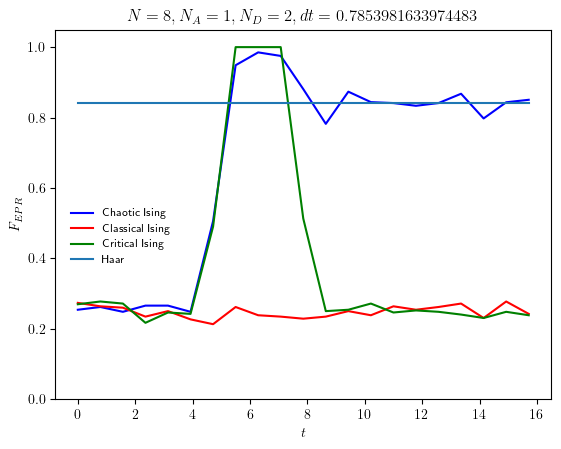

In [67]:
plt.plot(dt*times,Fepr_ch,"b-",label="Chaotic Ising")
plt.plot(dt*times,Fepr_cl,"r-",label="Classical Ising")
plt.plot(dt*times,Fepr_cr,"g-",label="Critical Ising")
plt.plot(dt*times,F_haar(NA,ND)+0*dt*times,"-",label="Haar")
plt.xlabel("$t$")
plt.ylabel(r"$F_{EPR}$")
plt.ylim([0,1.05])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}, dt={dt}$")
legend=plt.legend(bbox_to_anchor=(0.0, 0.32), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

# OTOCの計算

$\langle 0|Z_x(t)Z_y(0)Z_x(t)Z_y(0)|0\rangle$を計算する

$\langle 0|U^\dagger Z_x U Z_y U^\dagger Z_x U|0\rangle$なので

状態$U^\dagger Z_x U|0\rangle$に対して$Z_y$の期待値を計算するればよい (初期状態がButterfly operatorの固有状態のときのみ正しい)

この場合Hadamard testは不要

以下$x=1$に固定して, $y$と$t$を変えた測定を行う

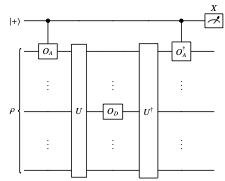

In [96]:
def U_ising(qc,q,h,m,dt):
    """
    exp(-i*dt*H_ising)
    h: coeff of transverse field
    m: coeff of longitudinal field
    """
    N = len(q)

    for i in range(N):
        X(qc,q[i],h*dt)

    for i in range(N):
        Z(qc,q[i],m*dt)

    for i in range(N-1):
        ZZ(qc,q[i],q[i+1],dt)
    #ZZ(qc,q[N-1],q[0],dt)

def U_ising_dag(qc,q,h,m,dt):
    """
    exp(-i*dt*H_ising)
    h: coeff of transverse field
    m: coeff of longitudinal field
    """
    N = len(q)

    #ZZ(qc,q[N-1],q[0],-dt)
    for i in reversed(range(N-1)):
        ZZ(qc,q[i],q[i+1],-dt)

    for i in range(N):
        Z(qc,q[i],-m*dt)

    for i in range(N):
        X(qc,q[i],-h*dt)

def cU_ising(qc,q,h,m,dt):
    """
    c-exp(-i*dt*H_ising)
    This is used to compute the vacuum persistence amplitude
    h: coeff of transverse field
    m: coeff of longitudinal field
    q[0] is the control qubit; N+1 qubits in total
    """
    Nq = len(q)

    for i in range(1,Nq):
        CX(qc,q[0],q[i],h*dt)

    for i in range(1,Nq):
        CZ(qc,q[0],q[i],m*dt)

    for i in range(1,Nq-1):
        CZZ(qc,q[0],q[i],q[i+1],dt)
    CZZ(qc,q[0],q[Nq-1],q[1],dt)


In [97]:
class TFI:
    def __init__(self,N,h,m,T,dt):
        self.N = N
        self.h = h
        self.m = m
        self.dt= dt
        self.M = int(T/dt)

    def measurement(self):

        OTOC    = np.zeros((self.M+1,self.N))
        OTOCerr    = np.zeros((self.M+1,self.N))

        for i in range(self.M+1):

            backend = BasicSimulator()
            q = QuantumRegister(self.N,"q")
            qc = QuantumCircuit(q)
            
            op = []
            for j in range(self.N):
                op1= [('Z' ,[j],1.0)]
                op1=SparsePauliOp.from_sparse_list(op1 , num_qubits=len(q))
                op.append(op1)

            for _ in range(i):
                U_ising(qc,q,self.h,self.m,self.dt)

            qc.z(q[0])

            for _ in range(i):
                U_ising_dag(qc,q,self.h,self.m,self.dt)

            estimator= BackendEstimator(backend=backend)
            result = estimator.run([(qc,op)]).result()[0].data
            OTOC[i,]=result.evs
            OTOCerr[i,]=result.stds
        return OTOC,OTOCerr
    
    def hadamard(self):

        OTOC    = np.zeros((self.M+1,self.N))
        OTOCerr    = np.zeros((self.M+1,self.N))

        for i in range(self.M+1):
            for j in range(self.N):

                backend = BasicSimulator()
                q = QuantumRegister(self.N,"q")
                qh = QuantumRegister(1,"qh")
                qc = QuantumCircuit(q,qh)
            
                op = []
                op1= [('X' ,[self.N],1.0)]
                op1=SparsePauliOp.from_sparse_list(op1 , num_qubits=len(q)+len(qh))
                op.append(op1)

                qc.h(qh)
                qc.cx(qh,q[j])

                for _ in range(i):
                    U_ising(qc,q,self.h,self.m,self.dt)

                qc.x(q[0])

                for _ in range(i):
                    U_ising_dag(qc,q,self.h,self.m,self.dt)

                qc.cx(qh,q[j])

                estimator= BackendEstimator(backend=backend)
                result = estimator.run([(qc,op)]).result()[0].data
                OTOC[i,j]=result.evs[0]
                OTOCerr[i,j]=result.stds[0]

        return OTOC,OTOCerr


In [117]:
N=8
hx=1.05
hz=0.5
T=10
dt=0.1

In [118]:
q=TFI(N,hx,hz,T,dt)

In [119]:
z,zerr=q.measurement()

In [120]:
x,xerr=q.hadamard()

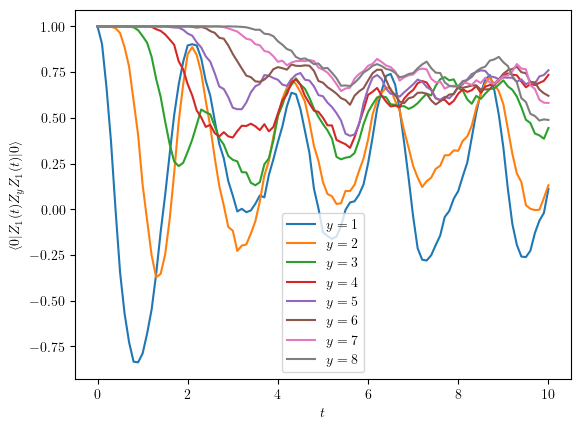

In [121]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,z[:,0], '-',label=r"$y=1$")
plt.plot(times,z[:,1], '-',label=r"$y=2$")
plt.plot(times,z[:,2], '-',label=r"$y=3$")
plt.plot(times,z[:,3], '-',label=r"$y=4$")
plt.plot(times,z[:,4], '-',label=r"$y=5$")
plt.plot(times,z[:,5], '-',label=r"$y=6$")
plt.plot(times,z[:,6], '-',label=r"$y=7$")
plt.plot(times,z[:,7], '-',label=r"$y=8$")

plt.xlabel("$t$")
plt.ylabel(r"$\langle0|Z_1(t)Z_yZ_1(t)|0\rangle$")
plt.legend()
plt.show()

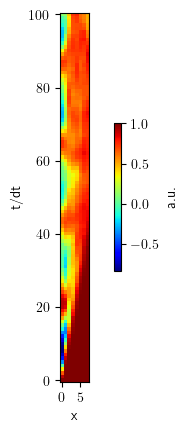

In [126]:
plt.tight_layout()
plt.imshow(z, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.xlabel('x')
plt.ylabel('t/dt')
plt.show()

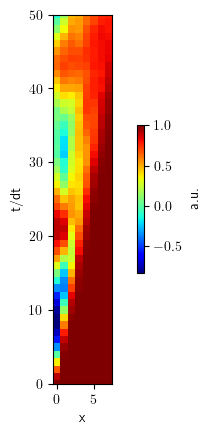

In [129]:
plt.tight_layout()
plt.imshow(z, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.ylim([0,50])
plt.xlabel('x')
plt.ylabel('t/dt')
plt.show()

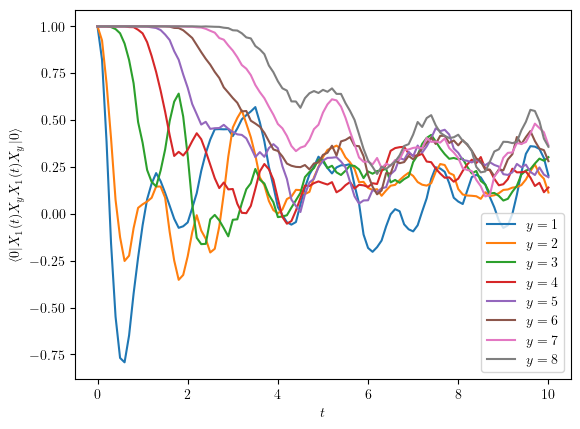

In [122]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,x[:,0], '-',label=r"$y=1$")
plt.plot(times,x[:,1], '-',label=r"$y=2$")
plt.plot(times,x[:,2], '-',label=r"$y=3$")
plt.plot(times,x[:,3], '-',label=r"$y=4$")
plt.plot(times,x[:,4], '-',label=r"$y=5$")
plt.plot(times,x[:,5], '-',label=r"$y=6$")
plt.plot(times,x[:,6], '-',label=r"$y=7$")
plt.plot(times,x[:,7], '-',label=r"$y=8$")

plt.xlabel("$t$")
plt.ylabel(r"$\langle0|X_1(t)X_yX_1(t)X_y|0\rangle$")
plt.legend()
plt.show()

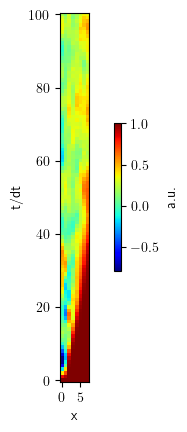

In [124]:
plt.tight_layout()
plt.imshow(x, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.xlabel('x')
plt.ylabel('t/dt')
plt.show()

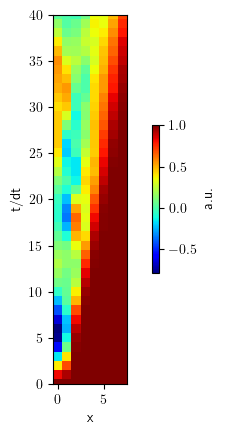

In [131]:
plt.tight_layout()
plt.imshow(x, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.ylim([0,40])
plt.xlabel('x')
plt.ylabel('t/dt')
plt.show()

### Floqut scrambling

In [106]:
N=8
hx=1.05
hz=0.5
dt=pi/4
T=20*dt

In [107]:
q=TFI(N,hx,hz,T,dt)

In [108]:
z,zerr=q.measurement()

In [109]:
x,xerr=q.hadamard()

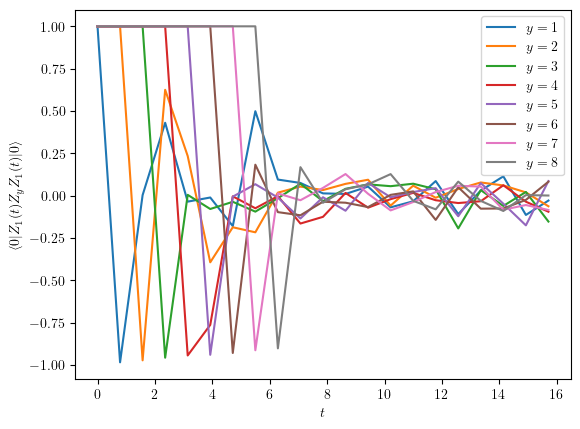

In [116]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,z[:,0], '-',label=r"$y=1$")
plt.plot(times,z[:,1], '-',label=r"$y=2$")
plt.plot(times,z[:,2], '-',label=r"$y=3$")
plt.plot(times,z[:,3], '-',label=r"$y=4$")
plt.plot(times,z[:,4], '-',label=r"$y=5$")
plt.plot(times,z[:,5], '-',label=r"$y=6$")
plt.plot(times,z[:,6], '-',label=r"$y=7$")
plt.plot(times,z[:,7], '-',label=r"$y=8$")

plt.xlabel("$t$")
plt.ylabel(r"$\langle0|Z_1(t)Z_yZ_1(t)|0\rangle$")
plt.legend()
plt.show()

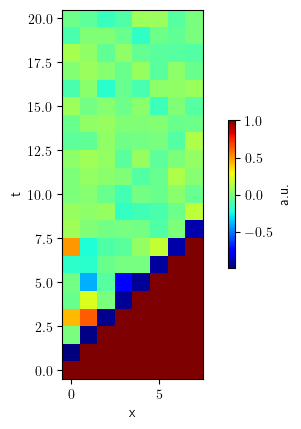

In [113]:
plt.tight_layout()
plt.imshow(z, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.xlabel('x')
plt.ylabel('t')
plt.show()

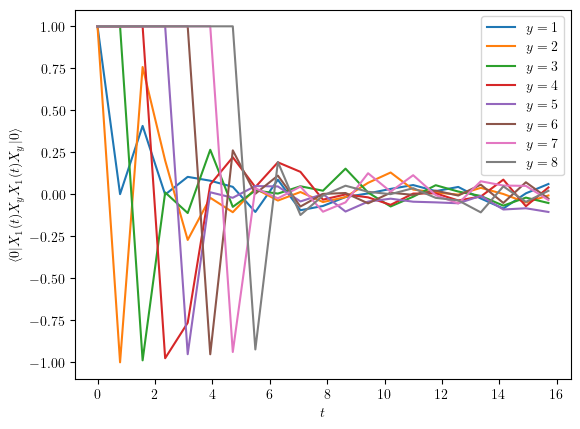

In [115]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,x[:,0], '-',label=r"$y=1$")
plt.plot(times,x[:,1], '-',label=r"$y=2$")
plt.plot(times,x[:,2], '-',label=r"$y=3$")
plt.plot(times,x[:,3], '-',label=r"$y=4$")
plt.plot(times,x[:,4], '-',label=r"$y=5$")
plt.plot(times,x[:,5], '-',label=r"$y=6$")
plt.plot(times,x[:,6], '-',label=r"$y=7$")
plt.plot(times,x[:,7], '-',label=r"$y=8$")

plt.xlabel("$t$")
plt.ylabel(r"$\langle0|X_1(t)X_yX_1(t)X_y|0\rangle$")
plt.legend()
plt.show()

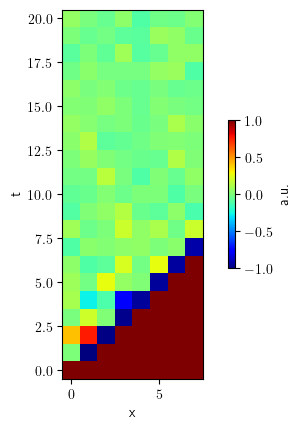

In [114]:
plt.tight_layout()
plt.imshow(x, cmap='jet', origin='lower')
plt.colorbar(shrink=0.4, label="a.u.")
plt.xlabel('x')
plt.ylabel('t')
plt.show()